# Lab 3 - Nim  
## Task3.4: An agent using reinforcement learning  

In [1]:
import logging
import random
from copy import deepcopy
import matplotlib.pyplot as plt

from nim import Nimply, Nim
from play_nim import opponents, evaluate

In [2]:
logging.basicConfig(format="%(message)s", level=logging.INFO)

## Implementation

In [3]:
def hash_id(state: list, player: int):
  """
    Computes the hash of the tuple tuple(state) + (player, ), where:
    - state is the list of rows, i.e. the board
    - player is either 0 or 1
  """
  assert player == 1 or player == 0
  return hash(tuple(state) + (player, ))

#### Node class from Task 3

In [4]:
class Node():
  """
    State of the grapth that contains:
    - id: hash of tuple(state)+(player,)
    - state: copy of the state (nim._rows)
    - player: either 0 or 1
    - reward: value initialized to 0, becomes either 100 (win) or -100 (lose)
    - children: list of nodes
    - parents: list of nodes 
    - actions: list of possible actions as Nimply objects
  """

  def __init__(self, state: list, player: int):
    assert player == 1 or player == 0
    
    self.id = hash_id(state, player)
    self.state = deepcopy(state)
    self.player = player # Me (0) -> max ; Opponent (1) -> min
    
    self.reward = 0 
    self.children = []
    self.parents = []
    self.possible_acitions() # creates self.actions


  def __eq__(self, other):
    return isinstance(other, Node) and self.state == other.state and self.player == other.player


  def link_parent(self, parent):
    """
      Links the actual node with the parent node
    """
    assert isinstance(parent, Node)
    assert self.player != parent.player

    if parent not in self.parents:
      self.parents.append(parent)


  def link_child(self, child):
    """
      Links the child node to the actual node
    """
    assert isinstance(child, Node)
    assert self.player != child.player

    if child not in self.children:
      self.children.append(child)


  def is_game_over(self):
    return sum(self.state) == 0

  
  def give_reward(self):
    """
    Returns the reward of the node
    - not end -> reward = -1  
    - win -> reward = 100  
    - lose -> reward = -100  
    """
    if not self.is_game_over():
      return -1
    if self.player == 0: # I lose
      return -100
    return 100 # I win


  def possible_acitions(self, k=None):
    """
      Computes all the possible action reachable from the actual node
      and saves them inside self.actions 
    """
    self.actions = []
    
    if self.is_game_over():
      return

    not_zero_rows = [(r, n) for r, n in enumerate(self.state) if n > 0]
    for row, num_obj in not_zero_rows:  
      while num_obj > 0:
        if k and num_obj > k:
          num_obj = k
          continue
        self.actions.append(Nimply(row, num_obj))
        num_obj -= 1


#### Game Tree (builded recursively, such us in task 3)

In [5]:
class GameTree():
  """
    Game Tree comosed of nodes that could have multiple parents and multiple children.
    Differently from task 3, this class expands the tree considering both player 1 and player 0 starting.
    
    The roots are two:
    - Starting state + starting player = 0 
    - Starting state + starting player = 1 
    The leafs are two:
    - State of all zeros + finish player = 0  (Agent loses)
    - State of all zeros + finish player = 1  (Agent wins)
    
    The class contains the following attributs:
    - k: nim._k
    - dict_id_node: dictionary that maps the node id to the actual node
    - dict_id_reward: dictionary that maps the node id to the state reward
    - root0: root node (Node object) when player 0 starts
    - root1: root node (Node object) when player 1 starts  

  """

  def __init__(self, nim: Nim):
    self.k = nim._k
    self.dict_id_node = {}   
    self.dict_id_reward = {} 

    # Build tree
    self.root0 = Node(nim._rows, player=0)
    self.root1 = Node(nim._rows, player=1)
    self.dict_id_node[self.root0.id] = self.root0
    self.dict_id_node[self.root1.id] = self.root1

    logging.info(f'Building the tree...')
    self.build_tree(self.root0)
    self.build_tree(self.root1)
    logging.info('Done')

  
  def build_tree(self, root):
    """
      Builds the tree using a recursive function that expands a node by trying every possible action of that node.

      The nodes are likend to each other, starting by the given root node.
    """
    
    def recursive(node: Node):
      # Stop condition
      if node.id in self.dict_id_reward:
        return
      
      if node.is_game_over():
        node.reward = node.give_reward()
        self.dict_id_reward[node.id] = node.reward
        return


      # Recursive part
      for ply in node.actions:
        row, num_obj = ply
        
        # Check rules
        assert node.state[row] >= num_obj
        assert self.k is None or num_obj <= self.k

        # Create the child
        child_state = deepcopy(node.state)
        child_state[row] -= num_obj # nimming
        child_id = hash_id(child_state, 1 - node.player)
        if child_id in self.dict_id_node: # node already exists
          child = self.dict_id_node[child_id]
        else: # create the new node
          child = Node(child_state, 1 - node.player)
          self.dict_id_node[child_id] = child
        
        # Link parent and child
        node.link_child(child)
        child.link_parent(node)

        # Recursion
        recursive(child)
          
      # Reward of the node (-1)
      node.reward = node.give_reward()
      self.dict_id_reward[node.id] = node.reward
    
      return 

    recursive(root)
    root.reward = root.give_reward()
  




#### Agent

In [6]:
class Agent():
  """
    The agent that will use Reinforcement Learning to learn to play nim.  
    This class in based on the maze example given by the professor.

    Attributes:
    alpha: learning rate
    random_factor: probability of making a random action
    state_history: history of the match played before learning
    G: dictionary that maps the id node to the expected reward (initialized randomly)
  """
  
  def __init__(self, game_tree: GameTree, alpha=0.5, random_factor=0.2):
    self.alpha = alpha
    self.random_factor = random_factor
    
    self.state_history = [] # node -> inside has state and reward
    self.G = {} # (k, v) = id_node, expected reward
    for id, node in game_tree.dict_id_node.items():
        self.G[id] = random.uniform(1.0, 0.1)


  def choose_action(self, node: Node):
    """
      Returns a Nimply by choosing the move that gives the maximum reward.
      With self.random_factor probability returns a random move. 
    """
    maxG = -10e15
    next_move = None
    
    # Random action
    if random.random() < self.random_factor:
      next_move = random.choice(node.actions)
    # Action with highest G (reward)
    else: 
      for a in node.actions:  # a is a Nimply obj
        new_state = deepcopy(node.state)
        new_state[a.row] -= a.num_objects
        new_state_id = hash_id(new_state, player=1) # opponent's state
        if self.G[new_state_id] >= maxG:
          next_move = a
          maxG = self.G[new_state_id]

    return next_move      
        

  def update_history(self, node: Node):
    self.state_history.append(node)


  def learn(self):
    """
      Update the internal G function by looking at the past
       using the formula G[s] = G[s] + a * (v - G[s]), where:
       - G[s] is the expected reward for the state s
       - a is alpha, the learning rate
       - v is the actual value associated to that state

      After the learning part, it reset the history and decreases the random factor by 10e-5
    """
    target = 0

    for node in reversed(self.state_history):
      self.G[node.id] = self.G[node.id] + self.alpha * (target - self.G[node.id])
      target += node.reward

    self.state_history = []     # Restart
    self.random_factor -= 10e-5 # Decrease random factor each episode of play

    

#### Evaluatation function

In [7]:
def play(nim: Nim, game_tree: GameTree, agent: Agent, n_matches=40, *, opponent_action: callable, alternate_turns=True):
  """
    This function simulated n_matches games between the agent and the given opponent.

    If alternate_turns == True, than the games will have as strating player the player 0 
     50 % of the time and player 1 50% of the time.
    
    If alternate_turns == False, the player 0 will always start the match.
  """

  # Agent is player 0
  won = 0
  for m in range(n_matches):
    # Setup the match
    nim_tmp = deepcopy(nim)

    if alternate_turns:
      if m/n_matches > 0.5:
        player = 1 # The agent starts
      else:
        player = 0 # Opponent starts  
    else:
      player = 0 # The agent always starts
      
    # Play the match
    while not nim_tmp.is_game_over():
      player = 1 - player
      if player == 1:
        ply = opponent_action(nim_tmp)
      else: # player 0
        state_id = hash_id(nim_tmp._rows, player)
        node = game_tree.dict_id_node[state_id]
        ply = agent.choose_action(node)
      nim_tmp.nimming(ply)

    if player == 0:
      won += 1
  
  return won/n_matches


#### Reinforcement Learning algorithm

In [8]:
def RL_nim(nim: Nim, game_tree: GameTree, agent: Agent, opponent: callable, episodes = 5000, alternate_turns=True):
  """
    A match is played by the agent aganst the given opponent episodes times.

    At each episode, the agent learns looking at the rewards that it receved.

    Every 50 epochs, the agent plays versus the opponent using the function play(•) above, 
    in order to look how many matches it wins.

    The win rates are sotred inside a log list that is returned
  
  """
  log_winrate = [] # episode, value 

  for e in range(episodes):
    # Play a game
    episode_nim = deepcopy(nim)

    if alternate_turns:
      if e % 2 == 0:
        state = game_tree.root0 # the agent starts
      else:
        state = game_tree.root1 # the opponent starts
    else:
      state = game_tree.root0 # The agent always starts

    while not episode_nim.is_game_over():
      # My turn
      if state.player == 0:
        my_action = agent.choose_action(state) # Choose an action
        episode_nim.nimming(my_action)         # Update the state
        if episode_nim.is_game_over():
          break

        # Get new state and reward
        new_state_id = hash_id(episode_nim._rows, player = 1)
        state = game_tree.dict_id_node[new_state_id]
        agent.update_history(state)
      
      # Opponent turn
      else:
        opp_action = opponent(episode_nim)
        episode_nim.nimming(opp_action)
        if episode_nim.is_game_over():
          break
        new_state_id = hash_id(episode_nim._rows, player = 0)
        state = game_tree.dict_id_node[new_state_id]
      
    # Log
    if e % 50 == 0:
      winrate = play(nim, game_tree, agent, opponent_action=opponent, alternate_turns=alternate_turns)
      logging.debug(f'{e}: winrate = {winrate}')
      log_winrate.append((e, winrate))
    
  return log_winrate


#### Plot funcion

In [9]:
def plot_agent_winrates(log_winrate):
  x = [e for e, w in log_winrate]
  y = [w for e, w in log_winrate]
  plt.xlabel('Episodes')
  plt.ylabel('Win rate')
  plt.plot(x, y)
  plt.show()
  

---
---

## Play

In [10]:
nim = Nim(5)
game_tree= GameTree(nim)
agent = Agent(game_tree)

Building the tree...
Done


#### Agent vs Dumb player

Agent winrate from (0, 0.825) to (49980, 0.875) 


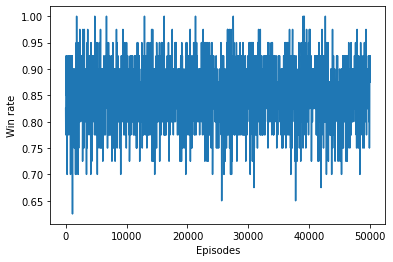

In [11]:
opponent = opponents[1]
log_lv1 = RL_nim(nim, game_tree, agent, opponent=opponent, episodes=50000, alternate_turns=False)
logging.info(f'Agent winrate from {log_lv1[0]} to {log_lv1[len(log_lv1)-1]} ')
plot_agent_winrates(log_lv1)

#### Agent vs Dumb random player

Agent winrate from (0, 0.55) to (49980, 0.7) 


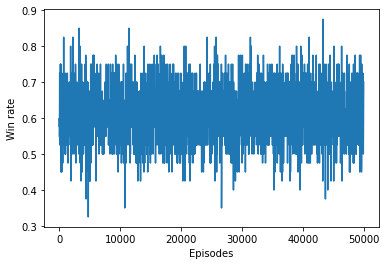

In [12]:
opponent = opponents[2]
log_lv1 = RL_nim(nim, game_tree, agent, opponent=opponent, episodes=50000, alternate_turns=False)
logging.info(f'Agent winrate from {log_lv1[0]} to {log_lv1[len(log_lv1)-1]} ')
plot_agent_winrates(log_lv1)

#### Agent vs Random player

Agent winrate from (0, 0.575) to (49980, 0.575) 


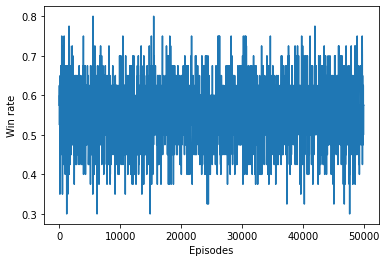

In [13]:
opponent = opponents[3]
log_lv1 = RL_nim(nim, game_tree, agent, opponent=opponent, episodes=50000, alternate_turns=False)
logging.info(f'Agent winrate from {log_lv1[0]} to {log_lv1[len(log_lv1)-1]} ')
plot_agent_winrates(log_lv1)

#### Agent vs Layered player

Agent winrate from (0, 0.525) to (49980, 0.5) 


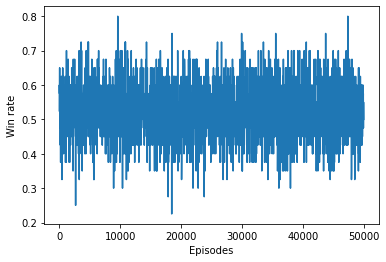

In [14]:
opponent = opponents[4]
log_lv1 = RL_nim(nim, game_tree, agent, opponent=opponent, episodes=50000, alternate_turns=False)
logging.info(f'Agent winrate from {log_lv1[0]} to {log_lv1[len(log_lv1)-1]} ')
plot_agent_winrates(log_lv1)

#### Agent vs Demigod player (50% random - 50% num-sum)

Agent winrate from (0, 0.4) to (49980, 0.475) 


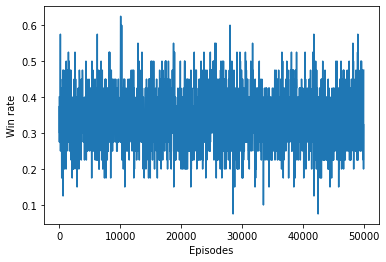

In [15]:
opponent = opponents[5]
log_lv1 = RL_nim(nim, game_tree, agent, opponent=opponent, episodes=50000, alternate_turns=False)
logging.info(f'Agent winrate from {log_lv1[0]} to {log_lv1[len(log_lv1)-1]} ')
plot_agent_winrates(log_lv1)

#### Agent vs God player (nim-sum)

Agent winrate from (0, 0.0) to (49980, 0.0) 


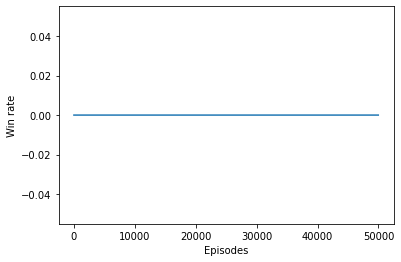

In [16]:
opponent = opponents[6]
log_lv1 = RL_nim(nim, game_tree, agent, opponent=opponent, episodes=50000, alternate_turns=False)
logging.info(f'Agent winrate from {log_lv1[0]} to {log_lv1[len(log_lv1)-1]} ')
plot_agent_winrates(log_lv1)